# Digit Classification using neural networks 

In [329]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

Reading the data


In [330]:
def load_data( data_path ):
    '''
    Loads the data from the specified path.
    
    Inputs:
    data_path: path to the directory containing the data files, each file containing measurement of a digit
    in a N x 3 matrix. 
    
    Returns:
    data: a list of numpy arrays, each array containing the measurement of a digit.
    labels: a list of labels corresponding to the data.
    '''
    files = os.scandir( data_path )

    data = []
    labels = []
    for file in files:
        filename = file.name
        if filename.endswith('.csv'):
            number_data = np.loadtxt(data_path + '/' + filename, delimiter=',', dtype=np.float32)
            label = int( filename.split('_')[1] )
            
            data.append( number_data )
            labels.append( label )      
                    
    return data, np.array(labels)

data_path = os.getcwd() + '/data/digits_3d/training_data'
data, labels = load_data( data_path )

Preprocess

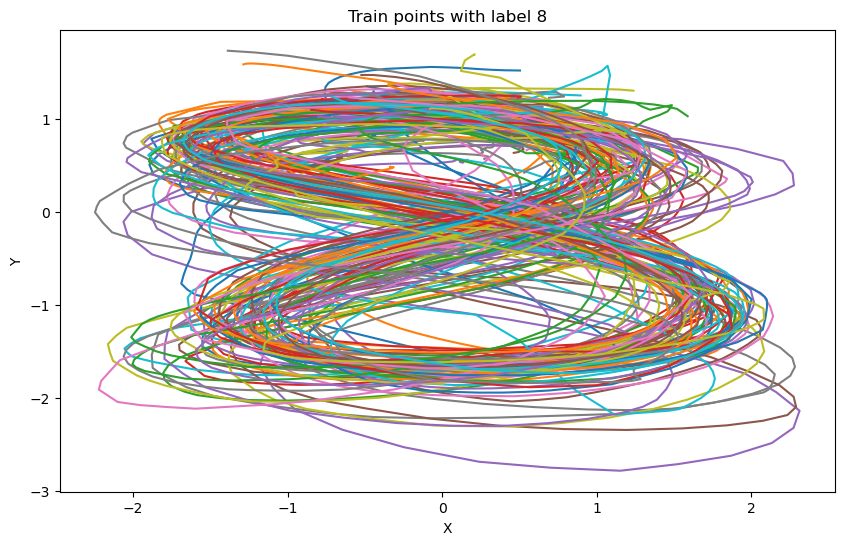

In [331]:
def preprocess_data( data, N_interp = 128 ):
    '''
    Preprocesses the data by interpolating to equal lengths and standardizing.
    
    Inputs:
    Data: list of numpy arrays, each array containing the measurement of a digit.
    N_interp: number of points to interpolate the variable-length data to.
    
    Returns:
    data: a list of numpy arrays, each array containing the measurement of a digit after preprocessing.
    '''
    scaler = StandardScaler()
    
    for ii, sample in enumerate( data ):
        N_sample, dims = sample.shape
        
        tt = np.linspace(0, 1, N_sample, dtype=np.float32)
        tt_interp = np.linspace(0, 1, N_interp, dtype=np.float32)
        
        # First, interpolation (for each dimension separately)
        sample_interp = np.zeros( (N_interp, dims), dtype=np.float32 )
        for dim in range( dims ):          
            dim_interp = np.interp( tt_interp, tt, sample[:, dim] )
            sample_interp[:, dim] = dim_interp
            
        # Then standardization
        data[ii] = scaler.fit_transform( sample_interp ).transpose()
        # print( data[ii].shape )
        
    return data

data = preprocess_data( data )

X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.2, stratify = labels ) 

# Find six train points with label 8
label_8_indices = [i for i, label in enumerate(y_train) if label == 8][:100]

# Plot them in the same figure
plt.figure(figsize=(10, 6))
for idx in label_8_indices:
    plt.plot(X_train[idx][0, :], X_train[idx][1, :], label=f'Sample {idx}')
# plt.legend()
plt.title('Train points with label 8')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Create Dataset and Dataloader objects

In [332]:
class NumberDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.number_labels = labels

    def __len__(self):
        return len(self.number_labels)

    def __getitem__(self, idx):
        image = data[idx]
        label = self.number_labels[idx]
        return image, label
    
train_dataset = NumberDataset(X_train, y_train)
test_dataset = NumberDataset(X_test, y_test)

train_dataloader = DataLoader( train_dataset )
test_dataloader = DataLoader( test_dataset )

Building the network, defining loss and optimizer

In [333]:
class NumberNetwork( nn.Module ) :
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # Input:1x3x128
        self.convolution_stack = nn.Sequential(
            nn.Conv1d( in_channels=3, out_channels=8, kernel_size=3, padding=1 ),  # Out:1x8x128
            nn.ReLU(),
            nn.MaxPool1d( kernel_size=2, stride=2 ),                    # Out:1x8x64
            
            nn.Conv1d( in_channels=8, out_channels=16, kernel_size=3, padding=1 ), # Out:1x16x64
            nn.ReLU(),
            nn.MaxPool1d( kernel_size=2, stride=2 ),                     # Out:1x16x32
            
            nn.Conv1d( in_channels=16, out_channels=32, kernel_size=3, padding=1 ), # Out:1x32x32
            nn.ReLU(),
            nn.MaxPool1d( kernel_size=2, stride=2 ),                     # Out:1x32x16
            
            nn.Conv1d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ),    # Out:1x64x16
            nn.ReLU(),
            nn.AdaptiveAvgPool1d( output_size=1 ),   # Out:1x64x1
            
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.Dropout(0.5),
            nn.Linear(32, 10)
        )
        
        # self.linear_stack = nn.Sequential(
        #     nn.Linear(input_size, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 36),§
        #     nn.ReLU(),
        #     nn.Linear(36, 10),

        #     # nn.Dropout( p=0.25 )
        # )
 
    def forward(self, x):
        # x = self.flatten(x)
        # logits = self.linear_stack(x)
        logits = self.convolution_stack(x)
        return logits
    
# Get CPU or GPU 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")
    
model = NumberNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )

Using cuda device


Defining train and test functions

In [334]:
def train( dataloader, model, loss_fn, optimizer ):
    N_data = len(dataloader.dataset)
    correct = 0
    total_loss = 0
    
    model.train()
    for ii, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute classification error
        train_class = model(X)
        loss = loss_fn( train_class, y ) 

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        print( train_class,"\n", train_class.argmax( dim=1 )[0], "\n", y.item(), "\n" )
        
        correct += train_class.argmax( dim=1 )[0] == y.item()
        # print( train_class.argmax( dim=1 )[0] == y.item())
        total_loss += loss.item()

        # if ii % 100 == 0:
        #     loss, current = loss.item(), (ii + 1)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{N_data:>5d}]")
        
        # print( train_class.argmax( dim=1 )[0], y.item() )
        
    accuracy = correct / N_data
    
    return accuracy, total_loss
            
def test( dataloader, model, loss_fn ):
    N_data = len(dataloader.dataset)
    correct = 0
    total_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_class = model(X)
            total_loss += loss_fn(test_class, y).item()
            correct += test_class.argmax( dim=1 )[0].item() == y.item()
       
    accuracy = correct/N_data
    
    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {total_loss:>8f} \n")
    
    return accuracy, total_loss

In [335]:
epochs = 
train_accuracy = []
train_losses = []
test_accuracy = []
test_losses = []
for t in tqdm(range(epochs), desc="Training Progress", leave=True):
    train_acc, train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_acc, test_loss = test(test_dataloader, model, loss_fn)
    
    if t % 5 == 0:
        print_str = f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        print(print_str)
    
    train_accuracy.append(train_acc.cpu().numpy())
    train_losses.append(train_loss)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)
print("Training finished!")


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 0.0433,  0.0731,  0.0823,  0.1057,  0.0994, -0.0495,  0.1642, -0.0705,
         -0.0691, -0.0818]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 tensor(6, device='cuda:0') 
 7 

tensor([[ 0.0699,  0.0609,  0.0984,  0.0982, -0.0052, -0.1058,  0.1787, -0.0732,
         -0.0560, -0.1089]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 tensor(6, device='cuda:0') 
 6 

tensor([[ 0.0798,  0.1132,  0.0260,  0.1333,  0.0683, -0.0912,  0.1570,  0.0033,
         -0.1068, -0.0899]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 tensor(6, device='cuda:0') 
 9 

tensor([[ 0.0629,  0.1594,  0.1023,  0.0713, -0.0437,  0.0021,  0.1598, -0.0572,
         -0.1490, -0.0833]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 tensor(6, device='cuda:0') 
 3 

tensor([[ 0.0349,  0.0526,  0.0498,  0.1238,  0.1137, -0.1074,  0.1882, -0.0450,
         -0.1050, -0.0878]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 tensor(6, device='cuda:0') 
 7 

tensor([[ 0.0731,  0.0952,  0.1238,  0.1029,  0.0234, -0.176

Training Progress: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

Test Error: 
 Accuracy: 10.0%, Avg loss: 460.741561 

Training finished!


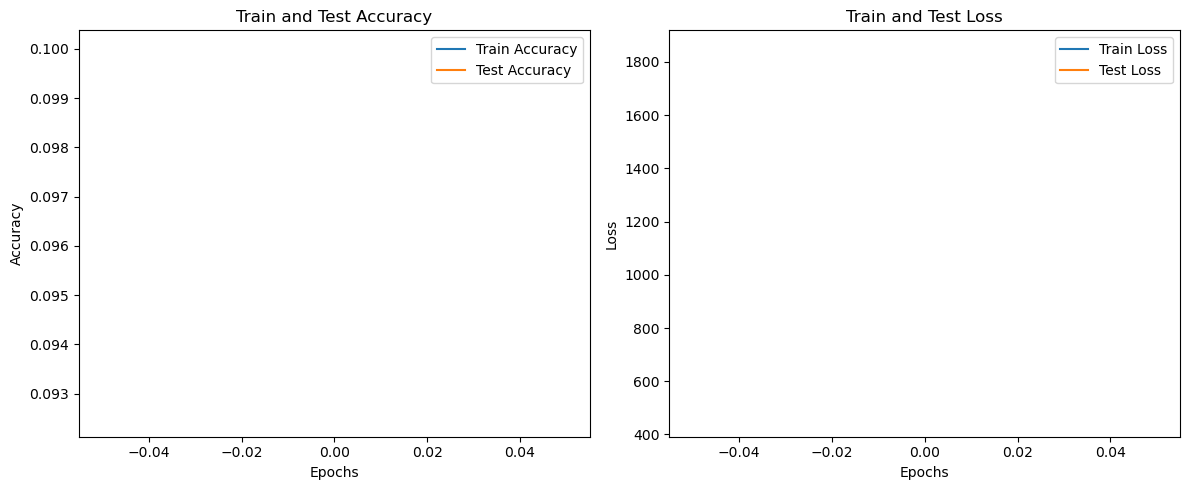

In [336]:
# Plot accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.tight_layout()
plt.show()